# Population Estimates: Define the income-level strata

In [4]:
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [5]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [38]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

# * Updated location for San Jose residential parcels
SJ_RES_PARCELS_FP = os.path.join(OAK_FP, 'san_jose_suppl', 'san_jose_parcels_res.geojson')

BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

# Load data 
cbg_sj_2016 = load_bg_shp(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP, year='2016')

# * Residential parcels
sj_parcels_res = gpd.read_file(SJ_RES_PARCELS_FP)
sj_parcels_res = sj_parcels_res[sj_parcels_res['APN'].notna()]

# * CBG income (includes interpolation for 15 CBGs with missing income data)
cbg_income_2016 = gpd.read_file(os.path.join(INPUT_FP, 'cbg_income_2016'))

# * Parcel confidences
parcel_conf_df = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Confidences_construction', 'parcel-confidence.csv'), dtype={'APN': str})

## 1. Income-level stratification

Shapefiles include 643 CBGs as of 2016 for San Jose. ACS has non-missing data for 628 CBGs; interpolated data has data for 13 out of these 15 CBGs. The other 2 CBGs include a county jail containing 7 residential parcels and a residential CBG containing only 24 residential parcels. We drop these two CBGs.

In [4]:
# Filter for SJ CBGs
cbg_income_2016_SJ = cbg_income_2016.loc[cbg_income_2016['GEOID'].isin(
        cbg_sj_2016['GEOID'].unique())].copy()

In [5]:
# Check missing CBGs and save shapefile of this subset
cbg_income_2016_SJ.info()

missing = cbg_income_2016_SJ.loc[cbg_income_2016_SJ['median_inc'].isna()]

#missing.to_file(os.path.join(OUTPUT_FP, '..', 'misc', 'missing-inc-cbgs'))

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 643 entries, 4 to 1070
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       643 non-null    object  
 1   median_inc  641 non-null    float64 
 2   geometry    643 non-null    geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 20.1+ KB


In [6]:
# Stratify
N_INCOME_BINS = 50
cbg_income_2016_SJ['strata_income'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=N_INCOME_BINS, 
    labels=['IS_{}'.format(i) for i in range(N_INCOME_BINS)])

In [7]:
# Define high vs. low-income neighborhoods
cbg_income_2016_SJ['neighborhood'] = cbg_income_2016_SJ['strata_income'].apply(
    lambda strata_income: 'low' if int(strata_income.split('_')[1]) < N_INCOME_BINS/2 else 'high'
)

In [8]:
# Convert strata from category to object
cbg_income_2016_SJ['strata_income'] = cbg_income_2016_SJ['strata_income'].astype('object')

In [9]:
# Add strata for the missing CBGs
cbg_income_2016_SJ['strata_income'] = cbg_income_2016_SJ['strata_income'].fillna('IS_MISSING')

In [26]:
cbg_income_2016_SJ.to_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

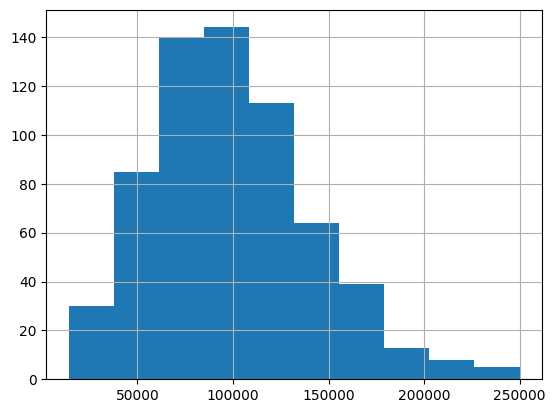

In [10]:
cbg_income_2016_SJ['median_inc'].hist()
plt.show()

## 2. Assign parcels to CBGs

In [10]:
sj_parcels = sj_parcels_res[['APN', 'geometry']].copy()

In [11]:
# Drop duplicate parcels
sj_parcels.drop_duplicates(subset=['APN'], inplace=True)
print('Number of parcels: {}'.format(len(sj_parcels)))

Number of parcels: 161299


In [12]:
# Filter parcels by area. We use an area threshold of 5,000 square meters as this
# provides a good trade-off between removing some non-SFRs in this area interval
# such as churches and apartment complexes, and starting to capture large SFRs
sj_parcels['area'] = sj_parcels.to_crs('EPSG:26910').geometry.area

AREA_THRESHOLD = 5000
sj_parcels = sj_parcels.loc[sj_parcels['area'] <= AREA_THRESHOLD]
print('Number of parcels: {}'.format(len(sj_parcels)))

Number of parcels: 159930


In [13]:
# Assign to CBGs
cbg_income_2016_SJ.reset_index(inplace=True, drop=True)
sj_parcels = sj_parcels.sjoin(cbg_income_2016_SJ[['GEOID', 'geometry']], how='left', predicate='intersects')

sj_parcels['CBG_iou'] = sj_parcels.progress_apply(
    lambda row: 0 if pd.isnull(row['index_right']) else row['geometry'].buffer(0).intersection(
        cbg_income_2016_SJ.iloc[int(row['index_right'])]['geometry'].buffer(0)).area/row['geometry'].buffer(0).area, 
    axis=1)

# Handle multiple matches
sj_parcels.sort_values('CBG_iou', ascending=False, inplace=True)
sj_parcels.drop_duplicates(subset=['APN'], keep='first', inplace=True)

sj_parcels.drop('index_right', axis=1, inplace=True)

print('Number of parcels: {}'.format(len(sj_parcels)))

100%|██████████| 160332/160332 [02:53<00:00, 926.56it/s]


Number of parcels: 159930


In [14]:
# Save
sj_parcels[['APN', 'GEOID', 'geometry']].to_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

In [20]:
sj_parcels[['APN', 'GEOID', 'geometry']].head()

,APN,GEOID,geometry
0,70616068,060855120352,"POLYGON ((-121.76364 37.23242, -121.76363 37.2..."
1,58332069,060855119051,"POLYGON ((-121.85785 37.21815, -121.85638 37.2..."
2,64709051,060855035081,"POLYGON ((-121.80662 37.35661, -121.80651 37.3..."
3,49926003,060855032112,"POLYGON ((-121.83067 37.30892, -121.83061 37.3..."
4,43927061,060855030013,"POLYGON ((-121.89886 37.28527, -121.89885 37.2..."


In [16]:
# Check residential parcels in missing income CBGs
sj_parcels = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

In [17]:
missing_parcels = sj_parcels.loc[sj_parcels['GEOID'].isin(missing['GEOID'])]
print(len(missing_parcels))

27


In [18]:
print(len(sj_parcels.loc[sj_parcels['GEOID'] == '060855034021'])) # 

print(len(sj_parcels.loc[sj_parcels['GEOID'] == '060855002002']))

23
4


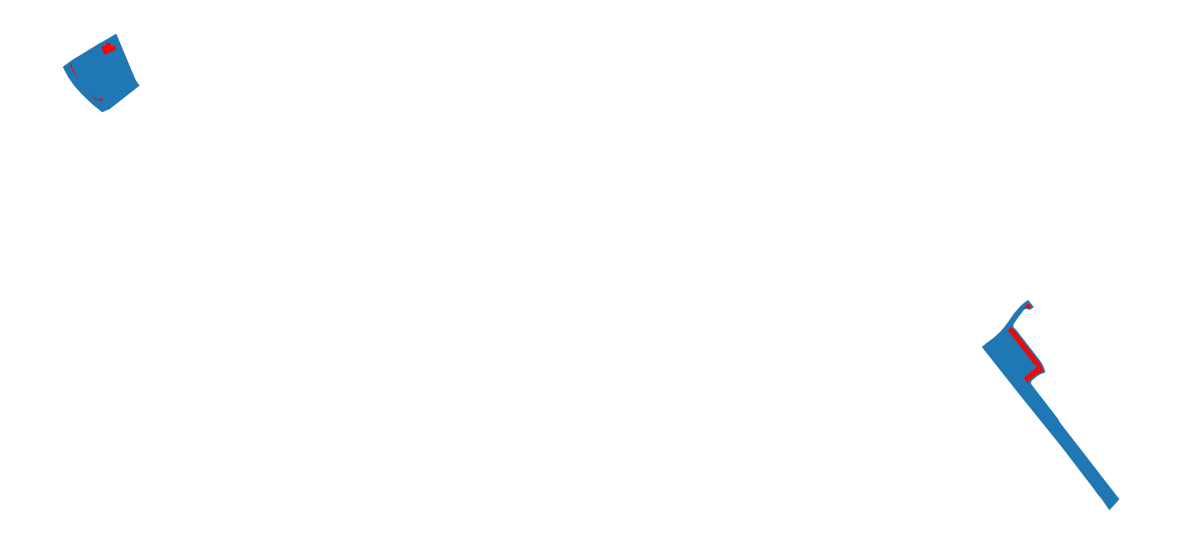

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
missing.plot(ax=ax),
missing_parcels.plot(ax=ax, color='red')
ax.axis('off')
plt.show()

## 3. Compute N_h

Requires the parcel-level confidences. 

In [60]:
# Parcels
sj_parcels = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# Load parcel confidences and subset to CF area
parcel_confidences = parcel_conf_df.copy()
parcel_confidences.rename(columns={'confidence': 'CBin'}, inplace=True)

# Generate income-confidence bins
parcel_confidences['Bin'] = parcel_confidences.apply(
    lambda row: '{}-{}'.format(row['strata_inc'], row['CBin']), axis=1)

# Save: shp including parcel, GEOID, bin
parcel_confidences = pd.merge(sj_parcels[['APN']], parcel_confidences[['APN', 'Bin']], 
                              how='left', validate='one_to_one')

parcel_confidences[['APN', 'Bin']].to_csv(
    os.path.join(OUTPUT_FP, 'Strata', 'sj_parcels_bins.csv'), index=False)

In [73]:
parcel_confidences = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Strata', 'sj_parcels_bins.csv'))

In [66]:
x = parcel_confidences.loc[parcel_confidences['Bin'].isna()]

In [70]:
parcel_conf_df.loc[parcel_conf_df['APN'].isin(x['APN'].unique())]

,APN,confidence,GEOID,strata_inc


In [72]:
len(x['APN'].unique())

61

In [62]:
parcel_confidences['Bin'].unique()

array(['IS_35-1', 'IS_40-1', 'IS_11-3', 'IS_22-1', 'IS_43-1', 'IS_12-1',
       'IS_29-1', 'IS_39-1', 'IS_13-1', 'IS_31-1', 'IS_36-1', 'IS_45-1',
       'IS_2-1', 'IS_10-3', 'IS_37-1', 'IS_32-1', 'IS_21-1', 'IS_33-3',
       'IS_49-1', 'IS_38-1', 'IS_21-3', 'IS_18-1', 'IS_33-1', 'IS_25-1',
       'IS_26-1', 'IS_41-1', 'IS_49-3', 'IS_9-1', 'IS_29-2', 'IS_24-3',
       'IS_33-2', 'IS_35-3', 'IS_34-1', 'IS_30-1', 'IS_7-1', 'IS_40-3',
       'IS_28-2', 'IS_16-1', 'IS_19-1', 'IS_10-1', 'IS_32-3', 'IS_32-2',
       'IS_0-1', 'IS_25-3', 'IS_24-1', 'IS_23-3', 'IS_42-1', 'IS_42-3',
       'IS_3-2', 'IS_47-1', 'IS_27-1', 'IS_11-1', 'IS_20-1', 'IS_42-2',
       'IS_MISSING-1', 'IS_46-1', 'IS_1-1', 'IS_19-2', 'IS_5-1',
       'IS_48-1', 'IS_13-3', 'IS_38-3', 'IS_20-3', 'IS_7-3', 'IS_16-3',
       'IS_23-1', 'IS_8-1', 'IS_31-3', 'IS_15-1', 'IS_28-3', 'IS_14-3',
       'IS_2-2', 'IS_3-1', 'IS_44-1', 'IS_7-2', 'IS_15-2', 'IS_47-3',
       'IS_34-2', 'IS_12-3', 'IS_17-1', 'IS_40-2', 'IS_44-2', 'IS_38-